In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import general necessary packages
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
# import the necessary packages -- cnn_regression
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from numpy.random import seed
from tensorflow import set_random_seed
from numpy import savez_compressed
from keras.callbacks import EarlyStopping

## Load Data

In [0]:
# define images data file path
path = "/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/"
train_dir = path + "Train/"
val_dir = path + "Validation/"
test_dir = path + "Test/"
result = path + "Model Results/"

In [0]:
# load image numpy array from npz file
from numpy import load
# load dict of arrays
train_data = load(path+'train_data.npz')
x_train = train_data['arr_0']
val_data = load(path+'val_data.npz')
x_val = val_data['arr_0']
test_data = load(path+'test_data.npz')
x_test = test_data['arr_0']

In [27]:
# import weather data
weather_data = pd.read_csv("/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/model_ready.csv")
weather_data.head()

,valid,tmpf,drct,sknt
0,2016-09-01 00:00:00,75.02,222.500000,5.125000
1,2016-09-01 01:00:00,73.94,202.857143,4.857143
2,2016-09-01 02:00:00,73.94,218.181818,4.272727
3,2016-09-01 03:00:00,73.94,204.444444,4.555556
4,2016-09-01 04:00:00,73.04,145.000000,2.700000


In [28]:
# convert valid columnto a timedate
weather_data['valid'] =  pd.to_datetime(weather_data['valid'])
# set valid column to index
weather_data = weather_data.set_index('valid')
weather_data.isna().sum()

tmpf    21
drct     7
sknt     3
dtype: int64

In [31]:
weather_data[weather_data.sknt == 0]

,tmpf,drct,sknt
valid,,,
2016-09-01 15:00:00,69.98,0.0,0.0
2016-09-04 00:00:00,62.96,0.0,0.0
2016-09-10 06:00:00,73.04,0.0,0.0
2016-09-12 09:00:00,51.08,0.0,0.0
2016-09-13 06:00:00,55.04,0.0,0.0
...,...,...,...
2017-08-24 10:00:00,57.90,0.0,0.0
2017-08-26 10:00:00,51.10,0.0,0.0
2017-08-28 04:00:00,55.00,0.0,0.0


In [33]:
# Filling missing values with 0
weather_data = weather_data.fillna(0)
weather_data.head()

,tmpf,drct,sknt
valid,,,
2016-09-01 00:00:00,75.02,222.500000,5.125000
2016-09-01 01:00:00,73.94,202.857143,4.857143
2016-09-01 02:00:00,73.94,218.181818,4.272727
2016-09-01 03:00:00,73.94,204.444444,4.555556
2016-09-01 04:00:00,73.04,145.000000,2.700000


In [0]:
# fill the 0 with the past 5 hous mean
# sknt column
for i in range(0,8719):
  if weather_data.iloc[i][2] == 0:
    weather_data['sknt'].iloc[i] = total = weather_data['sknt'].iloc[i-5:i].mean()

In [35]:
weather_data[weather_data.sknt == 0] # no 0's in sknt

,tmpf,drct,sknt
valid,,,


In [0]:
# set train and test dataset
a = pd.Timestamp('2017/06/01 00:00:00')
b = pd.Timestamp('2017/08/01 00:00:00')
sample = weather_data[weather_data.index < b]
train = weather_data[weather_data.index < a]
val = sample[sample.index >= a]
test = weather_data[weather_data.index >= b]
# separate the data into train, validation and test
# sknt model
y_train_1 = train['sknt']
y_val_1 = val['sknt']
y_test_1 = test['sknt']

In [37]:
# check the shape
print("Image train dataset shape: ", x_train.shape, "Weather train dataset shape: ", train.shape)
print("Image validation dataset shape: ", x_val.shape, "Weather validation dataset shape: ", val.shape)
print("Image test dataset shape: ", x_test.shape, "Weather test dataset shape: ", test.shape)

Image train dataset shape:  (6511, 125, 145, 3) Weather train dataset shape:  (6511, 3)
Image validation dataset shape:  (1464, 125, 145, 3) Weather validation dataset shape:  (1464, 3)
Image test dataset shape:  (744, 125, 145, 3) Weather test dataset shape:  (744, 3)


## CNN Regression

In [0]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Dropout(0.3))

model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Dropout(0.3))

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model1.add(tf.keras.layers.Dropout(0.3))

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(256, activation='relu'))
model1.add(tf.keras.layers.Dense(128, activation='relu'))

model1.add(tf.keras.layers.Dense(1, activation='linear'))

In [0]:
model1.compile(optimizer='rmsprop',loss="mse", metrics=['mae'])

In [0]:
es1 = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=5, 
                   verbose=1)

In [46]:
# train the model
print("[INFO] training model...")
history1 = model1.fit(x_train, y_train_1, validation_data=(x_val, y_val_1), epochs=300, batch_size=5,verbose=1,callbacks=[es1])

[INFO] training model...
Train on 6511 samples, validate on 1464 samples
Epoch 1/300
6511/6511 [==============================] - 30s 5ms/sample - loss: 1747.4706 - mean_absolute_error: 5.4584 - val_loss: 12.2526 - val_mean_absolute_error: 2.7567
Epoch 2/300
6511/6511 [==============================] - 23s 4ms/sample - loss: 15.2570 - mean_absolute_error: 3.0007 - val_loss: 8.8750 - val_mean_absolute_error: 2.3629
Epoch 3/300
6511/6511 [==============================] - 23s 4ms/sample - loss: 12.3001 - mean_absolute_error: 2.6923 - val_loss: 7.8530 - val_mean_absolute_error: 2.2111
Epoch 4/300
6511/6511 [==============================] - 23s 4ms/sample - loss: 10.4242 - mean_absolute_error: 2.4646 - val_loss: 6.0580 - val_mean_absolute_error: 1.9397
Epoch 5/300
6511/6511 [==============================] - 23s 4ms/sample - loss: 9.5138 - mean_absolute_error: 2.3601 - val_loss: 5.1376 - val_mean_absolute_error: 1.7851
Epoch 6/300
6511/6511 [==============================] - 23s 4ms/sampl

In [51]:
# let's try to extract from history.history
x = np.array(history1.epoch)
x = max(x)
print("We should re-run for this many epochs: ", x)

We should re-run for this many epochs:  9


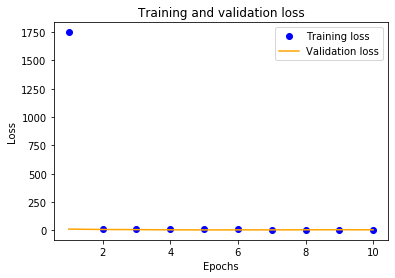

In [52]:
# let's see the training and validation loss by epoch
history1_dict = history1.history
loss_values = history1_dict['loss'] # you can change this
val_loss_values = history1_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) #acc wasn't defined before
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model1.save("/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/ConvNet_WindRegression_Model_srs19003.h5")

[INFO] predicting wind Speed...


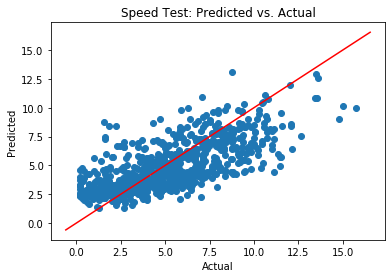

In [54]:
# make predictions on the testing data
print("[INFO] predicting wind Speed...")
preds1_test = model1.predict(x_test)
plt.scatter(y_test_1, preds1_test)
plt.title('Speed Test: Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
x = np.linspace(*plt.xlim())
plt.plot(x,x,color='red')
plt.savefig(result+'Speed Test.png')

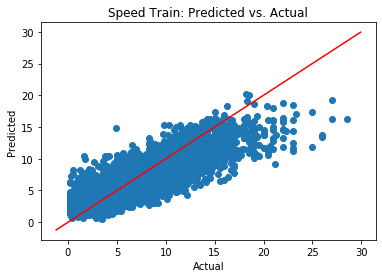

In [55]:
# actual vs. predicted on training
preds1_train = model1.predict(x_train)
plt.scatter(y_train_1,preds1_train)
plt.title('Speed Train: Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
x = np.linspace(*plt.xlim())
plt.plot(x,x,color='red')
plt.savefig(result+'Speed Training.png')

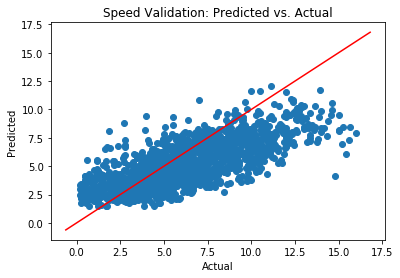

In [56]:
# actual vs. predicted on Validation
preds1_Val = model1.predict(x_val)
plt.scatter(y_val_1,preds1_Val)
plt.title('Speed Validation: Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
x = np.linspace(*plt.xlim())
plt.plot(x,x,color='red')
plt.savefig(result+'Speed Validation.png')

In [57]:
results_sknt = model1.evaluate(x_test, y_test_1)
results_sknt

744/744 [==============================] - 1s 717us/sample - loss: 4.4230 - mean_absolute_error: 1.6464


[4.423030668689359, 1.6464095]

In [58]:
# Train dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds1_train)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_speed"}, inplace=True)
myPreds['Type'] = 'train'
#actual predictions
myActual = pd.DataFrame(np.array(y_train_1))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_speed"}, inplace=True)
allResults_speed1 = pd.concat([myActual,myPreds], axis=1)
allResults_speed1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6511 entries, 0 to 6510
Data columns (total 3 columns):
actual_speed    6511 non-null float64
preds_speed     6511 non-null float32
Type            6511 non-null object
dtypes: float32(1), float64(1), object(1)
memory usage: 127.3+ KB


In [59]:
# Test dataset
# flatten the 1-D numpy array
myPreds = np.ndarray.flatten(preds1_test)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "preds_speed"}, inplace=True)
myPreds['Type'] = 'test'
#actual predictions
myActual = pd.DataFrame(np.array(y_test_1))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_speed"}, inplace=True)
allResults_speed2 = pd.concat([myActual,myPreds], axis=1)
allResults_speed2.head()

,actual_speed,preds_speed,Type
0,8.833333,4.400661,test
1,6.076923,4.060831,test
2,4.615385,3.734385,test
3,3.307692,3.420371,test
4,3.076923,2.896009,test


In [0]:
# Saving seperate csv files for train and test
allResults_speed1.to_csv ('/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/allResults_speed1.csv')

In [0]:
allResults_speed2.to_csv ('/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/allResults_speed2.csv')

## Binary Classification Model for Air Temperature

In [0]:
# fill the 0 with the past 5 hous mean
# tmpf column
for i in range(0,8719):
  if weather_data.iloc[i][0] == 0:
    weather_data['tmpf'].iloc[i] = total = weather_data['tmpf'].iloc[i-5:i].mean()

In [0]:
# Binary Classification
import statistics as st
above_avg = weather_data[weather_data['tmpf']>= weather_data['tmpf'].mean()]
below_avg = weather_data[weather_data['tmpf']< weather_data['tmpf'].mean()]

In [68]:
# Creating Flag as Binary target
above_avg['Flag_temp'] = 1
below_avg['Flag_temp'] = 0
binary_data = pd.concat([above_avg,below_avg], axis=0)
binary_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tmpf,drct,sknt,Flag_temp
valid,,,,
2016-09-01 00:00:00,75.02,222.500000,5.125000,1
2016-09-01 01:00:00,73.94,202.857143,4.857143,1
2016-09-01 02:00:00,73.94,218.181818,4.272727,1
2016-09-01 03:00:00,73.94,204.444444,4.555556,1
2016-09-01 04:00:00,73.04,145.000000,2.700000,1


In [69]:
binary_data = binary_data.drop(['tmpf'],axis=1)
binary_data.head()

,drct,sknt,Flag_temp
valid,,,
2016-09-01 00:00:00,222.500000,5.125000,1
2016-09-01 01:00:00,202.857143,4.857143,1
2016-09-01 02:00:00,218.181818,4.272727,1
2016-09-01 03:00:00,204.444444,4.555556,1
2016-09-01 04:00:00,145.000000,2.700000,1


In [0]:
# set train and test dataset
a = pd.Timestamp('2017/06/01 00:00:00')
b = pd.Timestamp('2017/08/01 00:00:00')
sample = binary_data[binary_data.index < b]
train = binary_data[binary_data.index < a]
val = sample[sample.index >= a]
test = binary_data[binary_data.index >= b]
# separate the data into train, validation and test
y_train_2 = train['Flag_temp']
y_val_2 = val['Flag_temp']
y_test_2 = test['Flag_temp']

In [73]:
# check the shape
print("Image train dataset shape: ", x_train.shape, "Weather train dataset shape: ", train.shape)
print("Image validation dataset shape: ", x_val.shape, "Weather validation dataset shape: ", val.shape)
print("Image test dataset shape: ", x_test.shape, "Weather test dataset shape: ", test.shape)

Image train dataset shape:  (6511, 125, 145, 3) Weather train dataset shape:  (6511, 3)
Image validation dataset shape:  (1464, 125, 145, 3) Weather validation dataset shape:  (1464, 3)
Image test dataset shape:  (744, 125, 145, 3) Weather test dataset shape:  (744, 3)


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
 modelCL = tf.keras.Sequential()

 modelCL.add(tf.keras.layers.Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', input_shape=(125,145,3))) 
 modelCL.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 modelCL.add(tf.keras.layers.Dropout(0.3))

 modelCL.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
 modelCL.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 modelCL.add(tf.keras.layers.Dropout(0.3))

 modelCL.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
 modelCL.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 modelCL.add(tf.keras.layers.Dropout(0.3))

 modelCL.add(tf.keras.layers.Flatten())
 modelCL.add(tf.keras.layers.Dense(256, activation='relu'))
 modelCL.add(tf.keras.layers.Dense(128, activation='relu'))

 modelCL.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 modelCL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return modelCL

modelCL=KerasClassifier(build_fn=create_model)  

In [0]:
es2 = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=5, 
                   verbose=1)

In [77]:
# train the model
print("[INFO] training model...")
history2 = modelCL.fit(x_train, y_train_2, validation_data=(x_val, y_val_2), epochs=300, batch_size=5,verbose=1,callbacks=[es2])

[INFO] training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6511 samples, validate on 1464 samples
Epoch 1/300
6511/6511 [==============================] - 23s 4ms/sample - loss: 0.9600 - acc: 0.8621 - val_loss: 0.7759 - val_acc: 0.7903
Epoch 2/300
6511/6511 [==============================] - 23s 3ms/sample - loss: 0.2550 - acc: 0.9080 - val_loss: 0.6537 - val_acc: 0.7507
Epoch 3/300
6511/6511 [==============================] - 22s 3ms/sample - loss: 0.2257 - acc: 0.9106 - val_loss: 0.4370 - val_acc: 0.8989
Epoch 4/300
6511/6511 [==============================] - 22s 3ms/sample - loss: 0.2298 - acc: 0.9157 - val_loss: 0.4707 - val_acc: 0.9044
Epoch 5/300
6511/6511 [==============================] - 22s 3ms/sample - loss: 0.2143 - acc: 0.9169 - val_loss: 0.8918 - val_acc: 0.8272
Epoch 6/300
6511/6511 [==============================] - 22s 3ms/sample - loss: 0.1916 - acc: 0.9232 - val_loss: 1.1372 - val_acc: 0.8313
Epoch

In [78]:
# let's try to extract from history.history
x = np.array(history2.epoch)
x = max(x)
print("We should re-run for this many epochs: ", x)

We should re-run for this many epochs:  7


In [0]:
modelCL.model.save("/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/ConvNet_TempClassification_Model_srs19003.h5")

In [0]:
#NN Test
CL_test = modelCL.predict(x_test)

In [82]:
from sklearn.metrics import accuracy_score
CL_test_score = accuracy_score(y_test_2, CL_test)
print("Dense Neural Network Test Accuracy Score = ", CL_test_score)

Dense Neural Network Test Accuracy Score =  0.9946236559139785


In [83]:
# Confusion Matrix Test
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_2, CL_test))

,0,1
0,0,4
1,0,740


In [84]:
# Confusion Matrix Train
CL_train = modelCL.predict(x_train)
pd.DataFrame(confusion_matrix(y_train_2, CL_train))

,0,1
0,4216,46
1,383,1866


In [85]:
# Confusion Matrix Validation
CL_val = modelCL.predict(x_val)
pd.DataFrame(confusion_matrix(y_val_2, CL_val))

,0,1
0,0,50
1,240,1174


In [86]:
CL_train_prob = modelCL.predict_proba(x_train)
CL_test_prob = modelCL.predict_proba(x_test)
print(CL_test_prob)

[[0.00799108 0.9920089 ]
 [0.00772178 0.9922782 ]
 [0.00801539 0.9919846 ]
 ...
 [0.01687205 0.98312795]
 [0.0154469  0.9845531 ]
 [0.01731306 0.98268694]]


In [88]:
# Train dataset
# flatten the 1-D numpy array
#predicted
myPreds = np.ndarray.flatten(CL_train)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "pred_temp"}, inplace=True)
myPreds['Type'] = 'train'
#predicted probabilities
myProb = np.ndarray.flatten(CL_train_prob)
myProb = pd.DataFrame(myProb)
myProb.reset_index(drop=True)
myProb.rename(columns={0: "pred_temp_prob"}, inplace=True)
#actual predictions
myActual = pd.DataFrame(np.array(y_train_2))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_temp"}, inplace=True)
allResults_temp1 = pd.concat([myActual,myPreds,myProb], axis=1)
allResults_temp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13022 entries, 0 to 13021
Data columns (total 4 columns):
actual_temp       6511 non-null float64
pred_temp         6511 non-null float64
Type              6511 non-null object
pred_temp_prob    13022 non-null float32
dtypes: float32(1), float64(2), object(1)
memory usage: 356.2+ KB


In [89]:
allResults_temp1.head()

,actual_temp,pred_temp,Type,pred_temp_prob
0,1.0,1.0,train,0.004465
1,1.0,1.0,train,0.995535
2,1.0,1.0,train,0.005360
3,1.0,1.0,train,0.994640
4,1.0,1.0,train,0.003700


In [92]:
# Test dataset
# flatten the 1-D numpy array
#predicted
myPreds = np.ndarray.flatten(CL_test)
myPreds = pd.DataFrame(myPreds)
myPreds.reset_index(drop=True)
myPreds.rename(columns={0: "pred_temp"}, inplace=True)
myPreds['Type'] = 'test'
#predicted probabilities
myProb = np.ndarray.flatten(CL_test_prob)
myProb = pd.DataFrame(myProb)
myProb.reset_index(drop=True)
myProb.rename(columns={0: "pred_temp_prob"}, inplace=True)
#actual predictions
myActual = pd.DataFrame(np.array(y_test_2))
myActual.reset_index(drop=True)
myActual.rename(columns={0: "actual_temp"}, inplace=True)
allResults_temp2 = pd.concat([myActual,myPreds,myProb], axis=1)
allResults_temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 4 columns):
actual_temp       744 non-null float64
pred_temp         744 non-null float64
Type              744 non-null object
pred_temp_prob    1488 non-null float32
dtypes: float32(1), float64(2), object(1)
memory usage: 40.8+ KB


In [93]:
allResults_temp2.head()

,actual_temp,pred_temp,Type,pred_temp_prob
0,1.0,1.0,test,0.007991
1,1.0,1.0,test,0.992009
2,1.0,1.0,test,0.007722
3,1.0,1.0,test,0.992278
4,1.0,1.0,test,0.008015


In [0]:
#saving seperate csv file for training and test 
allResults_temp2.to_csv ('/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/allResults_temp2.csv')

In [0]:
allResults_temp1.to_csv ('/content/drive/My Drive/Deep Learning Spring 2020/Week 3 DL/Assignment 2/Cropped Image - Weather Project/Model Results/allResults_temp1.csv')

In [100]:
#Changing the cut off to 0.7
prob1 = modelCL.predict_proba(x_test)[:,1]
newpreds_test = [1 if i>0.7 else 0 for i in prob1]
pd.DataFrame(confusion_matrix(y_test_2, newpreds_test))


,0,1
0,0,4
1,0,740


In [97]:
#Changing the cut off to 0.3
prob2 = modelCL.predict_proba(x_test)[:,1]
newpreds_test = [1 if i>0.3 else 0 for i in prob2]
pd.DataFrame(confusion_matrix(y_test_2, newpreds_test))

,0,1
0,0,4
1,0,740


In [98]:
#Changing the cut off to 0.6
prob3 = modelCL.predict_proba(x_test)[:,1]
newpreds_test = [1 if i>0.6 else 0 for i in prob3]
pd.DataFrame(confusion_matrix(y_test_2, newpreds_test))

,0,1
0,0,4
1,0,740


In [99]:
#Changing the cut off to 0.9
prob4 = modelCL.predict_proba(x_test)[:,1]
newpreds_test = [1 if i>0.9 else 0 for i in prob4]
pd.DataFrame(confusion_matrix(y_test_2, newpreds_test))

,0,1
0,0,4
1,1,739
